# Field Validation

In [2]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [3]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_updated.csv')
#df.drop(columns=['Unnamed: 0'], inplace=True) 
df

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,1,2025-03-28 16:22:14.798,2025-03-28 16:22:15.291,16.443375,1.996765,-1.283295,19.369095,27.777527,29.927520,12.052414,...,10.840942,14.858414,10.098740,6.947967,7.034164,11.310211,11.171341,12.832916,13.182480,9.763550
2682,1,2025-03-28 16:22:15.297,2025-03-28 16:22:20.198,12.871231,15.298950,12.167328,6.507446,4.898544,10.793060,14.676453,...,4.027054,16.352402,15.236694,1.853119,-0.871490,9.572021,15.729904,10.572800,0.057465,-0.823608
2683,1,2025-03-28 16:22:20.201,2025-03-28 16:22:20.695,10.534485,14.997284,9.686935,1.532288,4.223373,10.481812,11.621460,...,5.468353,8.595184,13.000519,10.860092,9.801865,4.520248,8.724472,13.666107,11.607086,5.535400
2684,1,2025-03-28 16:22:20.698,2025-03-28 16:22:21.190,0.430954,6.354217,10.826584,11.386826,4.587295,1.154007,9.184158,...,16.448166,22.376205,11.731583,1.762131,5.252884,11.281479,13.757080,8.930374,3.931274,14.647720


In [11]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']

# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape



((2171, 100), (515, 100))

In [5]:
# Make predictions using autoencoder
autoencoder = tf.keras.models.load_model('../../models/autoencoder_best.keras')
with open('../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\liuzi\AppData\Local\Temp\ipykernel_27548\1256496199.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


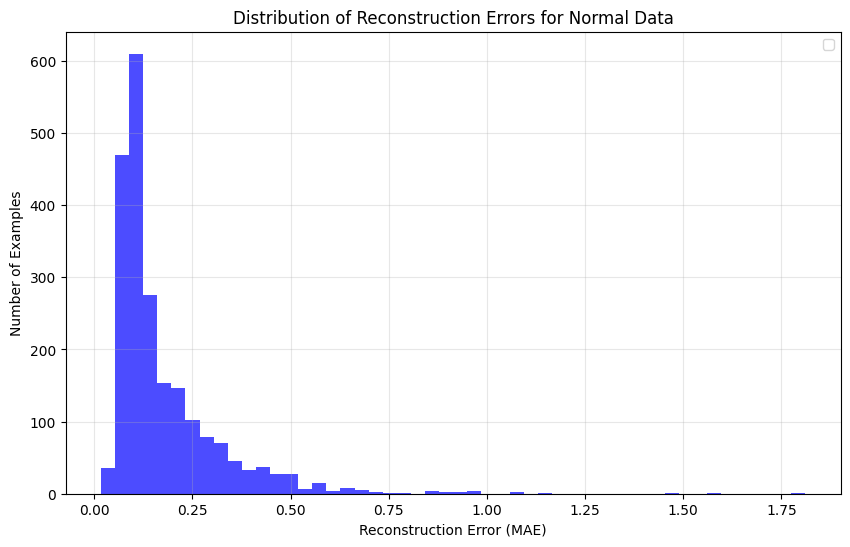

In [9]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = autoencoder.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal, bins=50, color='blue', alpha=0.7)

plt.title('Distribution of Reconstruction Errors for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
#plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


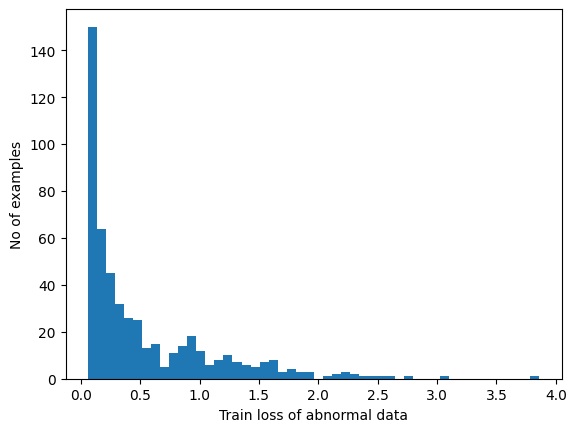

In [7]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = autoencoder.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal[None,:], bins=50)
plt.xlabel("Train loss of abnormal data")
plt.ylabel("No of examples")
plt.show()

In [23]:
# Find indices where reconstruction error > 1
train_loss_normal_np = train_loss_normal.numpy()  # Convert to numpy array
train_loss_abnormal_np = train_loss_abnormal.numpy()  # Convert to numpy array

normal_high_error_idx = np.where(train_loss_normal_np > 0.75)[0]
#abnormal_high_error_idx = np.where(train_loss_abnormal_np < 0.5)[0]

In [24]:
# Get original DataFrame rows for high error indices with additional information
normal_high_error_info = df[df['curb_scene'] == 0].iloc[normal_high_error_idx][['start_time', 'end_time', 'curb_scene']]
#abnormal_high_error_info = df[df['curb_scene'] == 1].iloc[abnormal_high_error_idx][['start_time', 'end_time', 'curb_scene']]

#Print results with reconstruction errors
# print("Time ranges for normal data with high reconstruction error (MAE > 1.5):")
# print("=================================================================")
# for idx, row in normal_high_error_info.iterrows():
#     error_value = train_loss_normal_np[normal_high_error_idx][normal_high_error_info.index.get_loc(idx)]
#     print(f"Index {idx}: {row['start_time']} to {row['end_time']}")
#     print(f"    Label: {row['curb_scene']} (Normal)")
#     print(f"    Reconstruction Error: {error_value:.3f}")

# print("\nTime ranges for abnormal data with high reconstruction error (MAE < 0.5):")
# print("===================================================================")
# for idx, row in abnormal_high_error_info.iterrows():
#     error_value = train_loss_abnormal_np[abnormal_high_error_idx][abnormal_high_error_info.index.get_loc(idx)]
#     print(f"Index {idx}: {row['start_time']} to {row['end_time']}")
#     print(f"    Label: {row['curb_scene']} (Abnormal)")
#     print(f"    Reconstruction Error: {error_value:.3f}")

# # Summary statistics
# print("\nSummary:")
# print(f"Number of high-error normal segments: {len(normal_high_error_info)}")
# # print(f"Number of high-error abnormal segments: {len(abnormal_high_error_info)}")
# # print(f"Average reconstruction error for high-error normal segments: {train_loss_normal_np[normal_high_error_idx].mean():.3f}")
# print(f"Average reconstruction error for high-error abnormal segments: {train_loss_abnormal_np[abnormal_high_error_idx].mean():.3f}")


In [25]:
# give me the index normal_high_error_idx = np.where(train_loss_normal_np > 1)[0] and change curb_scene to 1 in df

# Get the actual DataFrame indices for these samples
df_indices = df[df['curb_scene'] == 0].iloc[normal_high_error_idx].index
print(df_indices)


Index([ 136,  180,  226,  404,  478,  546, 1116, 1117, 1140, 1200, 1223, 1224,
       1225, 1226, 1227, 1228, 1229, 1231, 1232, 1233, 1234, 1248, 1281, 1315,
       1525, 1590, 1591, 1636, 1637, 1686, 1752, 1805, 1806, 1935, 1951, 1982,
       2021, 2022, 2024, 2095, 2242],
      dtype='int64')


In [ ]:
df_change_indices = [180,  226,  478,  546, 1140, 1200, 1248, 1281,
       1525, 1590, 1591, 1636, 1637, 1686, 1805, 1806, 1951, 1982,
       2021, 2022, 2024, 2095]
expanded_indices = []
for idx in df_indices:
    # Add previous, current, and next index
    expanded_indices.extend([idx-1, idx, idx+1])

# Remove duplicates and sort
expanded_indices = sorted(list(set(expanded_indices)))

In [28]:
# Get the loss values for the high error indices
loss_values = train_loss_normal_np[normal_high_error_idx]

# Create a DataFrame to display indices and their corresponding loss values
result_df = pd.DataFrame({
    'Index': df_indices,
    'Loss': loss_values,
    'Start Time': df.loc[df_indices, 'start_time'],
    'End Time': df.loc[df_indices, 'end_time']
})

# Sort by loss value to see highest errors first
result_df = result_df.sort_values('Index', ascending=True)

# Display the results
print("Indices and their reconstruction errors:")
print("=======================================")
print(result_df)
print(f"\nTotal samples with high error: {len(df_indices)}")
print(f"Average loss for these samples: {loss_values.mean():.3f}")

Indices and their reconstruction errors:
      Index      Loss               Start Time                 End Time
136     136  0.856826  2025-03-28 16:01:59.825  2025-03-28 16:02:00.321
180     180  0.863218  2025-03-28 16:02:25.676  2025-03-28 16:02:26.167
226     226  0.949976  2025-03-28 16:02:50.519  2025-03-28 16:02:51.012
404     404  0.863488  2025-03-28 16:04:26.913  2025-03-28 16:04:27.406
478     478  0.953862  2025-03-28 16:05:05.657  2025-03-28 16:05:08.144
546     546  0.930172  2025-03-28 16:05:41.420  2025-03-28 16:05:41.911
1116   1116  1.084314  2025-03-28 16:11:04.376  2025-03-28 16:11:04.869
1117   1117  0.962593  2025-03-28 16:11:04.873  2025-03-28 16:11:05.365
1140   1140  0.855698  2025-03-28 16:11:18.295  2025-03-28 16:11:20.787
1200   1200  0.760415  2025-03-28 16:12:02.100  2025-03-28 16:12:02.591
1223   1223  0.941669  2025-03-28 16:12:17.523  2025-03-28 16:12:18.015
1224   1224  0.951407  2025-03-28 16:12:18.019  2025-03-28 16:12:18.512
1225   1225  0.850405  

In [33]:
df_change_indices = [180,  226,  478,  546, 1140, 1200, 1248, 1281,
       1525, 1590, 1591, 1636, 1637, 1686, 1805, 1806, 1951, 1982,
       2021, 2022, 2024, 2095]
expanded_indices = []
for idx in df_change_indices:
    # Add previous, current, and next index
    expanded_indices.extend([idx-1, idx, idx+1])

# Remove duplicates and sort
expanded_indices = sorted(list(set(expanded_indices)))

In [34]:
# Create the expanded DataFrame
expanded_result_df = pd.DataFrame({
    'Index': expanded_indices,
    'Start Time': df.loc[expanded_indices, 'start_time'],
    'End Time': df.loc[expanded_indices, 'end_time']
})

# Sort by Index
expanded_result_df = expanded_result_df.sort_values('Index', ascending=True)
# Set display options to show all rows
pd.set_option('display.max_rows', None)
# Display the results
print("Expanded indices and their reconstruction errors:")
print("==============================================")
print(expanded_result_df)
print(f"\nTotal expanded samples: {len(expanded_indices)}")

Expanded indices and their reconstruction errors:
      Index               Start Time                 End Time
179     179  2025-03-28 16:02:25.180  2025-03-28 16:02:25.671
180     180  2025-03-28 16:02:25.676  2025-03-28 16:02:26.167
181     181  2025-03-28 16:02:26.173  2025-03-28 16:02:26.664
225     225  2025-03-28 16:02:50.023  2025-03-28 16:02:50.515
226     226  2025-03-28 16:02:50.519  2025-03-28 16:02:51.012
227     227  2025-03-28 16:02:51.017  2025-03-28 16:02:51.509
477     477  2025-03-28 16:05:05.161  2025-03-28 16:05:05.652
478     478  2025-03-28 16:05:05.657  2025-03-28 16:05:08.144
479     479  2025-03-28 16:05:08.150  2025-03-28 16:05:08.641
545     545  2025-03-28 16:05:40.922  2025-03-28 16:05:41.414
546     546  2025-03-28 16:05:41.420  2025-03-28 16:05:41.911
547     547  2025-03-28 16:05:41.916  2025-03-28 16:05:42.407
1139   1139  2025-03-28 16:11:17.798  2025-03-28 16:11:18.290
1140   1140  2025-03-28 16:11:18.295  2025-03-28 16:11:20.787
1141   1141  2025-03